# Project Summary: Predict New Medicines with BELKA

Reference MD. SHAIFUL ISLAM Notebook for the use of DuckDB and the ECFP

# Introduction:

The BELKA competition aims to harness machine learning to predict the binding affinity of small molecules to specific protein targets. This crucial step in drug development can significantly accelerate the discovery of new drugs by identifying potential candidates without extensive laboratory experiments. The dataset, provided by Leash Biosciences, includes binding interaction data between 133 million small molecules and three protein targets. The difficulty resides in the highly unbalanced non-binding over binding classes.

# Data Preparation:

**Loading Data:** The training and test data were loaded from parquet files.

**Sampling:** 
- Balance the dataset by randomly sampling a subset of binding and non-binding interactions.
- Correct for the class imbalance by using the Synthetic Minority Oversampling Technique SMOTE
  
**SMILES Conversion:** Converted SMILES strings to RDKit molecule objects for further processing.

**Feature Generation:** Generate fingerprints for each molecule, which served as molecular descriptors.
- Extended Connectivity Fingerprints (ECFP)
- RDK Fingerprints
- Standard molecular parameters (mass, number of valance eletrons, ...)
- Standard engineerd features from the fingerprints are added (sum, mean, std)

**Protein Encoding:** One-hot encoded the protein target names to include them as features in the model.

**Combining Features:** Combined descriptors and one-hot encoded protein names into a feature set.


# Model Development:

**Data Splitting:** Split the combined feature set and labels into training and validation sets.

**Model Selection:** 
- Choose the LightGBM and XGBoost classifiers due to their effectiveness in handling structured data and binary classification tasks.
- Other methods are tested as well

**Training:** 
- Train the LightGBM XGBoost models on the training set with specific parameters to optimize performance.

# Model Evaluation:

**Prediction:** Predicted binding probabilities on the validation set.

**Metrics:** Evaluated model performance using Mean Average Precision (mAP) and accuracy metrics.

# Visualization:

**Plot the distribution** of binding vs. non-binding interactions.

**Display the confusion matrix** to visualize true vs. false positives and negatives.

# Submission Preparation:
**Test Data Processing:** Processed the test dataset similarly to the training data (SMILES conversion, Fingerprint generation, and protein encoding).

**Prediction:** Predicted binding probabilities for the test set.

**Submission File:** Created a submission file with the required format and saved it for final submission.

# Conclusion:

This project strives for a robust approach to predicting small molecule-protein interactions using machine learning. The stakes are high since the machine method can increase manifold the speed of drug discovery but identifying the most promising candidates before any actual laboratory tests.

In [1]:
from rdkit import Chem
print("RDKit version:", Chem.rdBase.rdkitVersion)


RDKit version: 2022.09.5


# Import required libraries

In [2]:
import os
import pickle
from collections import Counter
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt, NumValenceElectrons
from rdkit.Chem.Descriptors import FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3

import duckdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier
import lightgbm as lgb
# https://github.com/scikit-fingerprints/scikit-fingerprints

In [3]:
from SmilesEnumerator import SmilesEnumerator

# Path to the train data

In [4]:

train_path = '/Volumes/MacExternal/kaggle/input/belka/train.parquet'

# Connect to DuckDB and load the data

In [5]:
con = duckdb.connect()
query = f"""(SELECT COUNT(*) FROM parquet_scan('{train_path}'))"""
nb_entries = con.execute(query).df().values[0][0]
query = f"""(SELECT COUNT(*) FROM parquet_scan('{train_path}') WHERE binds = 1)"""
nb_positive_binds = con.execute(query).df().values[0][0]
con.close()

In [6]:
print('Number of entries:', nb_entries)
nb_negative_binds = nb_entries - nb_positive_binds
print('Number of positive binds:', nb_positive_binds, 'Number of negative binds:', nb_negative_binds)
print('Ratio:', nb_positive_binds / nb_entries)

Number of entries: 295246830
Number of positive binds: 1589906 Number of negative binds: 293656924
Ratio: 0.005385006165857902


The binding fraction is extremly low making the training challenging

In [7]:
def read_batch(path, idstart, idend):
    """
    Read batch of data from idstart to idend

    Parameter
    ---------
    path : str
        the path the the parquet file
    idstart : int
        id start
    idend : int
        id end

    Returns
    -------
    : Pandas DataFrame
    """
    colnames = 'id, molecule_smiles, protein_name, binds'
    con = duckdb.connect()
    query = f"""(SELECT {colnames}
                 FROM parquet_scan('{path}')
                 WHERE id BETWEEN {idstart} AND {idend})
                 """
    df = con.execute(query).df()
    con.close()
    return df

In [8]:
def read_random_balanced_batch(path, limit_positive=30000, limit_negative=30000):
    """
    Get randomly LIMIT positive and LIMIT negative input

    Parameter
    ---------
    path : str
        the path the the parquet file

    LIMIT : int, optional, default=30000
        the number of positive and of negative rows

    Returns
    -------
    : Pandas DataFrame
    """
    colnames = 'id, molecule_smiles, protein_name, binds'
    con = duckdb.connect()
    query = f"""(SELECT id, molecule_smiles, protein_name, binds
                 FROM parquet_scan('{path}')
                 WHERE binds = 0
                 ORDER BY random()
                 LIMIT {limit_negative})
                 UNION ALL
                 (SELECT id, molecule_smiles, protein_name, binds
                 FROM parquet_scan('{path}')
                 WHERE binds = 1
                 ORDER BY random()
                 LIMIT {limit_positive})"""
    df = con.execute(query).df()
    con.close()
    return df

# Descriptors for a molecule

In [12]:
def generate_avg_rank(molecule):
    """
    Example
    -------
    >>> df['rank'] = df['molecule'].apply(generate_avg_rank)
    """
    if molecule is None:
        return None
    return np.array(Chem.CanonicalRankAtoms(molecule, breakTies=False)).mean()

# Function to generate ECFPs (Extended Connectivity Fingerprints)

In [13]:
# https://docs.chemaxon.com/display/docs/fingerprints_extended-connectivity-fingerprint-ecfp.md
def generate_ecfp(molecule, radius=2, bits=1024):
    """
    Example
    -------
    >>> df['ecfp'] = df['molecule'].apply(generate_ecfp)
    """
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

# Function to generate RDK Fingerprint

In [14]:
def generate_rdkfp(molecule):
    """
    Example
    -------
    >>> df['rdkfp'] = df['molecule'].apply(generate_rdkfp)
    """
    if molecule is None:
        return None
    return list(Chem.RDKFingerprint(molecule))

# Pipelin to process a batch

In [15]:
def process_batch(df, drop_SMILES=False):

    count = Counter(df['binds'])
    print('Original dataset shape %s' % Counter(df['binds']))
    print('Positive / negative:', count[1] / count[0])
    
    # convert SMILES to RDKit molecule objects
    print('Convert SMILES to RDKit molecule objects')
    df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
    
    # SMILES are not used
    if drop_SMILES:
        df.drop(labels=['molecule_smiles'], axis=1, inplace=True)

    # Add molecular descriptors
    df['rank'] = df['molecule'].apply(generate_avg_rank)
    df['ExactMolWt'] = df['molecule'].apply(ExactMolWt)  # The exact molecular weight of the molecule
    df['HeavyAtomMolWt'] = df['molecule'].apply(HeavyAtomMolWt)  # The average molecular weight of the molecule ignoring hydrogens
    print('Compute the number of valence electrons the molecule has')
    df['NumValenceElectrons'] = df['molecule'].apply(NumValenceElectrons)  # The number of valence electrons the molecule has

    # The density (= count of on-bits in the fingerprint divided by the heavy atom count in the molecule) of the morgan fingerprint. 
    # this means this will be a count of the total amount of unique morgan-type atomic environments (up to radius 1,2,3) 
    # in your molecule normalized by the heavy atom count.
    print('Morgan fingerprints')
    df['FpDensityMorgan1'] = df['molecule'].apply(FpDensityMorgan1)  # Morgan Fingerprint Density
    df['FpDensityMorgan2'] = df['molecule'].apply(FpDensityMorgan2)  #
    df['FpDensityMorgan3'] = df['molecule'].apply(FpDensityMorgan3)  #
    print('Compute ECFP')
    df['ecfp'] = df['molecule'].apply(generate_ecfp)
    
    # One-hot encode the protein_name column
    onehot_encoder = OneHotEncoder(sparse_output=False)
    protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))
    
    # Combine ECFPs and one-hot encoded protein names into the feature set
    X = np.hstack((np.array(df['ecfp'].tolist()), protein_onehot))
    y = df['binds'].values

    # Feature engineering
    # Counting for each molecule the number of 0 and 1
    count0, count1 = [], []
    for row in X:
        countbin = Counter(list(row))
        count0.append(countbin[0.0])
        count1.append(countbin[1.0])

    Xt = np.vstack((X.T, X.mean(1).T,
                X.sum(1).T,
                X.std(1).T,
                np.array(count0).T,
                np.array(count1).T,
                stats.hmean(X, 1),  # harmonic mean
                stats.mstats.gmean(X, 1),  # geometric mean
                stats.variation(X, 1),
                df['ExactMolWt'].values.T,
                df['HeavyAtomMolWt'].values.T,
                df['NumValenceElectrons'].values.T,
                df['FpDensityMorgan1'].values.T,
                df['FpDensityMorgan2'].values.T,
                df['FpDensityMorgan3'].values.T,
                df['rank'].values.T
                )).T

    # Scaler
    print('MinMax scaling')
    scaler = MinMaxScaler()
    Xs = scaler.fit_transform(Xt)
    print('End processing data')
    return Xt, Xs, y, df, protein_onehot, scaler

# SMOTE routines

In [16]:
def smote(X, y, SMOTE_frac=0.1):
    sm = SMOTE(sampling_strategy=SMOTE_frac, random_state=42) 
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [17]:
# Combining SMOTE with random undersampling of the majority class.
def resample(X, y, SMOTE_frac=0.1, UnderSample_frac=0.5):
    """
    Perform a SMOTE oversampling followed by a Random Undersampling
    """
    over = SMOTE(sampling_strategy=SMOTE_frac, random_state=42)  # SMOTE oversimpling
    under = RandomUnderSampler(sampling_strategy=UnderSample_frac, random_state=42)  # Random undersampling
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_res, y_res = pipeline.fit_resample(X, y)
    return X_res, y_res

# LVQ prototype generation

In [18]:
def init_lvq3(X, y, seed=2024):
    """
    Given the training set, compute the input weight/prototype for the LVQ3 learnign method
    """
    classes = np.unique(y)
    ly = len(y)
    ind = np.arange(0, ly, 1)
    train_idx = []
    for  c in classes:
        idx = np.random.choice(ind[y == c], size=1, replace=False)
        train_idx.append(idx[0]) 
    print('Train indices:', train_idx)
    W = X[train_idx].astype(np.float64)
    mask = np.ones(ly, dtype=bool)
    mask[train_idx] = False
    return X[mask, :], y[mask], W

In [19]:
#Train using LVQ 3
# LVQ can be used to generate prototypes
def lvq3_train(X, y, W, a, b, max_ep, min_a, e, verbose=False):
    """
    Perform training/fitting using the LVQ3  model

    Parameters
    ----------
    X : array-like
        training input

    y : array-like 
        labels

    a : float
        initial learning rate < 1, it should be around 0.1-0.5

    b : float
        b < 1
        learning rate decrease rate such that a_new = a_current * b

    W : array-like
        initial input prototype, see init_lvq3 for more details

    max_ep : int
        the maximum number of epochs

    min_a : float
        the minimum learning rate

    e : float
        dumping rate with 0 < e < 1

    verbose: bool, optional, default=False
        if True, the learning status will be displayed on the screen

    Return
    ------
    W : array-like
        the updated (learned) prototypes/weights

    c : 1D array
        the unique classes
    """
    c = np.unique(y)
    r = c
    ep = 0

    while ep < max_ep:
        if verbose:
            print('Epoch:', ep + 1, '/', max_ep, 'learning rate:', np.round(a, 5),
                  'min learning rate:', np.round(min_a, 5))
        for i, x in enumerate(X):
            d = [np.sum((w - x)**2) for w in W]
            min_1 = np.argmin(d)
            min_2 = 0
            dc = float(np.amin(d))
            dr = 0
            min_2 = d.index(sorted(d)[1])
            dr = float(d[min_2])
            if c[min_1] == y[i] and c[min_1] != r[min_2]:
                W[min_1] = W[min_1] + a * (x - W[min_1])

            elif c[min_1] != r[min_2] and y[i] == r[min_2]:
                if dc != 0 and dr != 0:
                    if min((dc / dr),(dr / dc)) > (1. - e) / (1. + e):
                        W[min_1] = W[min_1] - a * (x - W[min_1])
                        W[min_2] = W[min_2] + a * (x - W[min_2])
            elif c[min_1] == r[min_2] and y[i] == r[min_2]:
                W[min_1] = W[min_1] + e * a * (x - W[min_1])
                W[min_2] = W[min_2] + e * a * (x - W[min_2])
        a = a * b
        a = np.max([a, min_a])
        ep += 1
    return W, c

#Test Using LVQ 3
def lvq3_predict_proba(X, W, nb_importance):
    W1, c = W
    diff = np.abs(W1[1] - W1[0])
    j = np.flip(np.argsort(diff))
    j = j[0: nb_importance]
    d = np.array([np.sum(((w[j] - X[:, j])**2), 1) for w in W1])
    return d / d.sum(0)

#Evaluation
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels,
           preds, average = 'weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds,
           average = 'weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels,
           preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average =
           'weighted')))

In [20]:
def train_lvq(X, y, random_seed=2024, number_epochs=100, verbose=False):
    """
    Set the type required input and train a LVQ3 model
    """
    learning_starting_rate = 0.05 # 0.2
    learning_rate_decrease = 0.95
    minimum_learning_rate = 0.001
    m = 0.3  # 0.1 < m < 0.5 is a stabilizing constant.
    X_lvq_train, y_lvq_train, W_lvq = init_lvq3(X, y, seed=random_seed)
    W = lvq3_train(X_lvq_train, y_lvq_train, W_lvq , learning_starting_rate, learning_rate_decrease,
                   number_epochs, minimum_learning_rate, m, verbose=verbose)
    return W

In [21]:
def lvq3_score(X, y, W, features=1):
    """
    Average precision score using prediction made by the LVQ3 method
    """
    pred_lvq = lvq3_predict_proba(X, W, features)
    avg_precision_score = average_precision_score(y, pred_lvq[1,:])
    return avg_precision_score

In [ ]:
def lvq_balance_binary(X, y, random_seed=986, number_epochs=100):
    """
    Rebalance imbalanced classes using the LVQ prototyping method
    """
    count_y = Counter(y)
    W1 = train_lvq(X, y, random_seed=986, number_epochs=number_epochs)
    w1 = np.where(y == 1)[0]
    w0 = np.where(y == 0)[0]
    Xlvq = np.vstack((X[w0[0:count_y[1]], :], W1[0][0].T, X[w1, :], W1[0][1].T))
    ylvq = np.hstack((y[w0[0:count_y[1]]].T, [0], y[w1].T, [1]))
    return Xlvq, ylvq

# Split data into train and test sets

In [22]:
def split_random_balanced_batch(X, y, nb_positive_binds, nb_negative_binds, test_size=0.3, random_state=0):
    """
    X and y are data after processing
    Use together with read_random_balanced_batch
    """
    count = Counter(y)
    nb_test_negative = int(test_size * count[0])
    nb_test_positive = int(nb_test_negative * nb_positive_binds/ nb_negative_binds)
    print('Test positive:', nb_test_positive)
    print('Test negative:', nb_test_negative)
    y_train = np.append(y[0 : count[0] - nb_test_negative], y[count[0] : len(y) - nb_test_positive])
    y_test = np.append(y[count[0] - nb_test_negative : count[0]], y[len(y) - nb_test_positive :])
    
    X_train = np.vstack((X[0 : count[0] - nb_test_negative, :], X[count[0] : len(y) - nb_test_positive, :]))
    X_test = np.vstack((X[count[0] - nb_test_negative : count[0], : ], X[len(y) - nb_test_positive :, :]))
    # Randomize the orders
    rng = np.random.default_rng(random_state)
    arr_train = np.arange(len(y_train))
    rng.shuffle(arr_train)   
    X_train = X_train[arr_train, :]
    y_train = y_train[arr_train]
    rng = np.random.default_rng(random_state)
    arr_test= np.arange(len(y_test))
    rng.shuffle(arr_test)   
    X_test = X_test[arr_test, :]
    y_test = y_test[arr_test]
    return X_train, X_test, y_train, y_test

In [26]:
def save_pickle(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    file.close()


def read_pickle(filename):
    with open(filename, 'rb') as file:
        output = pickle.load(file)
    file.close()
    return output

In [ ]:
data_from_pickle = True
fit_models = False
feature_importance = False
resample_lvq = False
resample = False

In [27]:
if not data_from_pickle:
    #idstart = 1
    #idend = 100000
    #df = read_batch(train_path, idstart, idend)
    limit_positive = 30000
    limit_negative = limit_positive * 20  # 20 for 5%
    df = read_random_balanced_batch(train_path, limit_positive=limit_positive, limit_negative=limit_negative)
    Xt, Xs, y, df, protein_onehot, scaler = process_batch(df)
    df.to_pickle('belka2.pickle')
    save_pickle(Xt, 'Xt2.pickle')
    save_pickle(Xs, 'Xs2.pickle')
    save_pickle(y, 'y2.pickle')
    save_pickle(scaler, 'scaler2.pickle')
else:
    df = pdf.read_pickle('belka2.pickle')
    Xt = read_pickle('Xt2.pickle')
    Xs = read_pickle('Xs2.pickle')
    y = read_pickle('y2.pickle')
    scaler = read_pickle('scaler2.pickle')

In [ ]:
df.info()

# Split between training and testing sets
The correct application of oversampling during k-fold cross-validation is to apply
the method to the training dataset only, then evaluate the model on the stratified but 
non-transformed test set.

In [29]:

X_train, X_test, y_train, y_test = split_random_balanced_batch(Xs, y, nb_positive_binds, nb_negative_binds, test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)

Test positive: 974
Test negative: 180000


In [98]:
if resample:
    # X_train_res, y_train_res = resample(X_train, y_train, SMOTE_frac=0.5, UnderSample_frac=0.99)
    X_train_res, y_train_res = smote(X_train, y_train, SMOTE_frac=0.9)
    save_pickle(X_train_res, 'X_train_res2.pickle')
    save_pickle(y_train_res, 'y_train_res2.pickle')
else:
    X_train_res = read_pickle('X_train_res2.pickle')
    y_train_res = read_pickle('y_train_res2.pickle')

In [31]:
print('Train dataset shape %s' % Counter(y_train))

Train dataset shape Counter({0: 420000, 1: 29026})


In [32]:
count_test = Counter(y_test)
print('Test dataset shape %s' % count_test )

Test dataset shape Counter({0: 180000, 1: 974})


In [33]:
print('Test dataset ratio %s' % (count_test[1] / count_test [0]))

Test dataset ratio 0.005411111111111111


In [34]:
print('Original training dataset shape %s' % Counter(y_train))
print('Resampled training dataset shape %s' % Counter(y_train_res))

Original training dataset shape Counter({0: 420000, 1: 29026})
Resampled training dataset shape Counter({0: 420000, 1: 378000})


In [ ]:
# Use LVQ to generate one prototype for the binds and one for the non-binds
if resample_lvq:
    Xlvq_train, ylvq_train = lvq_balance_binary(X_train_res, y_train_res)
    save_pickle(Xlvq_train,'Xlvq_train2.pickle')
    save_pickle(ylvq_train,'ylvq_train2.pickle')
else:
    print('Read LVQ training from pickle')
    Xlvq_train = read_pickle('Xlvq_train2.pickle')
    ylvq_train = read_pickle('ylvq_train2.pickle'

Train indices: [160278, 568197]


In [36]:
print('Resampled training dataset shape %s' % Counter(ylvq_train))

Resampled training dataset shape Counter({0: 378001, 1: 378001})


# Initialize and train the LGBM model

In [37]:
def lgbm_feature_importance(X, y):
    lgb_params = {'verbosity': -1, 'n_estimators': 500, 'learning_rate': 0.01, 'metric': 'logloss',
                  'num_leaves': 250, 'max_depth': 15, 'random_state': 0, 'scale_pos_weight': 1}
    LGB = lgb.LGBMClassifier(**lgb_params)
    LGB.fit(X, y)
    max_num_features = 50
    lgb.plot_importance(LGB, importance_type="gain",
                        figsize=(12, 8), max_num_features=max_num_features,
                        title="LightGBM Feature Importance (Gain)")
    plt.show()

In [38]:
def train_lbg(X_train, y_train, X_test, y_test):

    # LGB model
    lgb_params = {'objective': 'binary',
                  'boosting_type': 'gbdt', 
                  'verbosity': -1,
                  'n_estimators': 550,
                  'learning_rate': 0.015,
                  'metric': None,
                  'num_leaves': 300,
                  'max_depth': 15,
                  'random_state': 0,
                  'scale_pos_weight': 1}
    return train_models(X_train, y_train, X_test, y_test, 'lgb', lgb_params)

# Initialize and train the XGBoost model

In [39]:
def train_xgb(X_train, y_train, X_test, y_test):
    xgb_params = {'n_estimators': 200,
                  'use_label_encoder': False,
                  'max_depth': 15,
                  'learning_rate': 0.2,
                  'eta': 0.2,  # learning rate default 0.3
                  'early_stopping_rounds': 100,
                  'eval_metric': 'logloss',
                  'seed': 202,
                  'min_child_weight': None,
                  'verbosity': 2,
                  }

    return train_models(X_train, y_train, X_test, y_test, 'xgb', xgb_params)

In [40]:
def train_models(X_train, y_train, X_test, y_test,
                 regressor, params, spl=5):

    # Vary the max_depth to obtain different models
    reg_test_preds, \
        reg_models = cross_val_train(X_train,
                               y_train,
                               X_test, y_test,
                               regressor,
                               params)
    return reg_models, reg_test_preds

In [41]:
def val_train(X, y, X_test, y_test, regressor, params,
              previous_model=None):

    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                          test_size=0.2, random_state=42)
    if regressor == 'xgb':
        model = XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    else:  # 'lgb'
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, init_model=previous_model,
                  eval_set=[(X_val, y_val)],
                  eval_metric='logloss',
                  callbacks=[lgb.early_stopping(stopping_rounds=50),
                              lgb.log_evaluation(100)])

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    #
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    train_accuracy = average_precision_score(y_train, y_pred_proba_train)
    test_accuracy = average_precision_score(y_test, y_pred_proba_test)

    train_auc = roc_auc_score(y_train, y_pred_train)
    test_auc = roc_auc_score(y_test, y_pred_test)

    
    print('Train average precision score:', train_accuracy)
    print('Test average precision score:', test_accuracy)

    print('Train auc score:', train_auc)
    print('Test auc score:', test_auc)

    return y_pred_test, model

In [42]:
def cross_val_train(X, y, X_test, y_test, regressor, params,
                    previous_model=None, spl=5):

    test_preds = []
    reg_models = []

    # Stratified Kfold
    # The dataset is stratified, meaning that each fold of the cross-validation
    # split will have the same class distribution as the original dataset,
    cv =  StratifiedKFold(n_splits=spl, random_state=42, shuffle=True)

    for fold, (train_ind, valid_ind) in enumerate(cv.split(X, y)):
        print("Fold:", fold + 1, "/", spl)
        print("Split the sample into train and validation")
        if isinstance(X, pd.core.frame.DataFrame):
            X_train = X.iloc[train_ind]
            X_val = X.iloc[valid_ind]
        else:
            X_train = X[train_ind, :]
            X_val = X[valid_ind, :]
        y_train = y[train_ind]
        y_val = y[valid_ind]

        if regressor == 'xgb':
            model = XGBClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        else:  # 'lgb'
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, init_model=previous_model,
                      eval_set=[(X_val, y_val)],
                      callbacks=[lgb.early_stopping(stopping_rounds=50),
                                 lgb.log_evaluation(100)])

        reg_models.append(model)
        y_pred_proba_trn = model.predict_proba(X_train)[:, 1]
        y_pred_proba_val = model.predict_proba(X_val)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
        test_preds.append(y_pred_proba_test)
        #
        train_precision = average_precision_score(y_train, y_pred_proba_trn)
        val_precision = average_precision_score(y_val, y_pred_proba_val)
        test_precision = average_precision_score(y_test, y_pred_proba_test)
        
        print("Fold:", fold + 1, " Train average precision score:", np.round(train_precision, 5),
              "Validation average precision score:", np.round(val_precision, 5),
              "Test average precision score:", np.round(test_precision, 5))

        print("-" * 60)

    test_preds = np.mean(test_preds, 0)
    test_precision_cv = np.round(average_precision_score(y_test, test_preds), 5)
    print('Final Test average accuracy score:', test_precision_cv)

    return test_preds, reg_models

In [43]:
def reg_predict(reg_models, X, y=None):
    ypred = []
    for i, model in enumerate(reg_models):
        if isinstance(model, list):
            ypred.append(predict_cv(X, model))
        else:
            ypred.append(model.predict(X))
        if y is not None:
            pred_average_precision_score = average_precision_score(y, ypred[i])
            print('Model ', i, 'average precision score:', pred_average_precision_score)
    ypred = np.array(ypred).mean(0)
    if y is not None:
        average_precision_score_cv = average_precision_score(y, ypred)
        print('Final test average precision score:', average_precision_score_cv)
    return ypred

In [44]:
def reg_predict(reg_models, X, y=None):
    ypred = []
    for i, model in enumerate(reg_models):
        if isinstance(model, list):
            ypred.append(predict_proba_cv(X, model))
        else:
            ypred.append(model.predict_proba(X)[:, 1])
        if y is not None:
            pred_average_precision_score = average_precision_score(y, ypred[i])
            print('Model ', i, 'accuracy score:', pred_average_precision_score)
    ypred_proba = np.array(ypred).mean(0)
    if y is not None:
        average_precision_score_cv = average_precision_score(y, ypred_proba)
        print('Final test average precision score:', average_precision_score_cv)
    return ypred_proba, np.rint(ypred_proba)

In [45]:
def predict_proba_cv(X, reg_models):
    ypred = []
    for model in reg_models:
        ypred.append(model.predict_proba(X)[:, 1])
    return np.array(ypred).mean(0)

In [46]:
def scores_and_plots(y_truth, ypred, ypred_proba):
    ap_score = average_precision_score(y_truth, ypred_proba)
    baccuracy = balanced_accuracy_score(y_truth, ypred)
    roc_auc = roc_auc_score(y_truth, ypred)
    # Calculating accuracy
    acc_score = accuracy_score(y_truth, ypred)  
    print(f"Average Precision (AP): {ap_score:.2f}")
    print(f"Accuracy score: {acc_score:.2f}")
    print(f"Balanced accuracy score: {baccuracy:.2f}")
    print(f"ROC:", roc_auc)
    cm = confusion_matrix(y_truth, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [47]:
def feval(label, ypred):
    return "avg_precision_score", average_precision_score(label, ypred), True

# Training and analysis

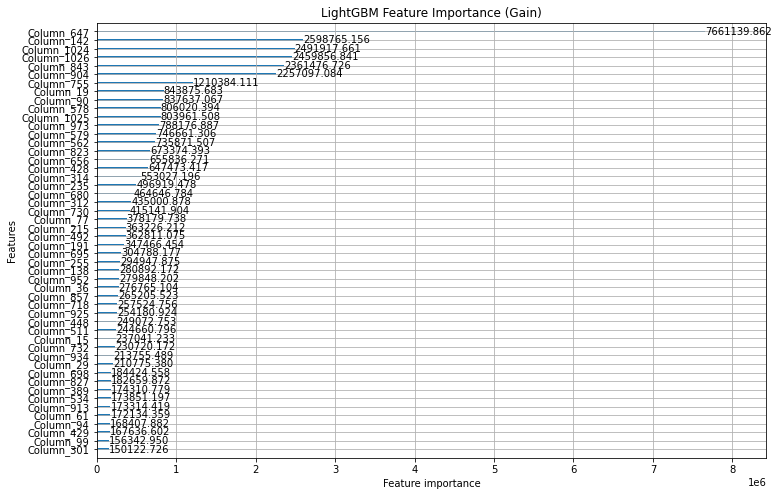

In [48]:
if feature_importance:
    lgbm_feature_importance(X_train_res, y_train_res)

In [55]:
if fit_models:
    lgb_models, lgb_test_preds = train_lbg(Xlvq_train, ylvq_train, X_test, y_test)
else:
    lgb_models = load_pickle('lgb_lvq_models2.pickle')

Fold: 1 / 5
Split the sample into train and validation
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.212187
[200]	valid_0's binary_logloss: 0.108232
[300]	valid_0's binary_logloss: 0.0744845
[400]	valid_0's binary_logloss: 0.0621289
[500]	valid_0's binary_logloss: 0.056378
Did not meet early stopping. Best iteration is:
[550]	valid_0's binary_logloss: 0.0543917
Fold: 1  Train average precision score: 0.99931 Validation average precision score: 0.9981 Test average precision score: 0.44308
------------------------------------------------------------
Fold: 2 / 5
Split the sample into train and validation
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.212867
[200]	valid_0's binary_logloss: 0.109282
[300]	valid_0's binary_logloss: 0.0752789
[400]	valid_0's binary_logloss: 0.0629987
[500]	valid_0's binary_logloss: 0.0573046
Did not meet early stopping. Best iteration is:
[550]	valid_0's binary_lo

In [56]:
if fit_models:
    save_pickle(lgb_models, 'lgb_lvq_models2.pickle')

In [57]:
if fit_models:
    lgb_res_models, lgb_res_test_preds = train_lbg(X_train_res, y_train_res, X_test, y_test)
else:
    lgb_res_models = read_pickle('lgb_res_models2.pickle')

Fold: 1 / 5
Split the sample into train and validation
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.212904
[200]	valid_0's binary_logloss: 0.108478
[300]	valid_0's binary_logloss: 0.0739271
[400]	valid_0's binary_logloss: 0.0615511
[500]	valid_0's binary_logloss: 0.0555511
Did not meet early stopping. Best iteration is:
[550]	valid_0's binary_logloss: 0.0535914
Fold: 1  Train average precision score: 0.99922 Validation average precision score: 0.99796 Test average precision score: 0.44487
------------------------------------------------------------
Fold: 2 / 5
Split the sample into train and validation
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.212434
[200]	valid_0's binary_logloss: 0.108229
[300]	valid_0's binary_logloss: 0.0736057
[400]	valid_0's binary_logloss: 0.0615755
[500]	valid_0's binary_logloss: 0.0555712
Did not meet early stopping. Best iteration is:
[550]	valid_0's binary_

In [58]:
if fit_models:
    save_pickle(lgb_res_models, 'lgb_res_models2.pickle')

In [59]:
if fit_models:
    xgb_models, xgb_test_preds = train_xgb(Xlvq_train, ylvq_train, X_test, y_test)
else:
    xgb_models = read_pickle('xgb_lvq_models2.pickle')

Fold: 1 / 5
Split the sample into train and validation
[0]	validation_0-logloss:0.54684
[1]	validation_0-logloss:0.44754
[2]	validation_0-logloss:0.37465
[3]	validation_0-logloss:0.31702
[4]	validation_0-logloss:0.27307
[5]	validation_0-logloss:0.23489
[6]	validation_0-logloss:0.20555
[7]	validation_0-logloss:0.18288
[8]	validation_0-logloss:0.16156
[9]	validation_0-logloss:0.14472
[10]	validation_0-logloss:0.13162
[11]	validation_0-logloss:0.11971
[12]	validation_0-logloss:0.10958
[13]	validation_0-logloss:0.10197
[14]	validation_0-logloss:0.09580
[15]	validation_0-logloss:0.09089
[16]	validation_0-logloss:0.08510
[17]	validation_0-logloss:0.08118
[18]	validation_0-logloss:0.07711
[19]	validation_0-logloss:0.07390
[20]	validation_0-logloss:0.07125
[21]	validation_0-logloss:0.06820
[22]	validation_0-logloss:0.06602
[23]	validation_0-logloss:0.06469
[24]	validation_0-logloss:0.06343
[25]	validation_0-logloss:0.06200
[26]	validation_0-logloss:0.06061
[27]	validation_0-logloss:0.05965
[28

In [60]:
if fit_models:
    save_pickle(xgb_models, 'xgb_lvq_models2.pickle')

In [61]:
if fit_models:
    xgb_res_models, xgb_res_test_preds = train_xgb(X_train_res, y_train_res, X_test, y_test)
else:
    xgb_res_models = read_pickle('xgb_res_models2.pickle')

Fold: 1 / 5
Split the sample into train and validation
[0]	validation_0-logloss:0.54826
[1]	validation_0-logloss:0.44872
[2]	validation_0-logloss:0.37584
[3]	validation_0-logloss:0.31934
[4]	validation_0-logloss:0.27595
[5]	validation_0-logloss:0.23848
[6]	validation_0-logloss:0.21121
[7]	validation_0-logloss:0.18416
[8]	validation_0-logloss:0.16281
[9]	validation_0-logloss:0.14493
[10]	validation_0-logloss:0.13110
[11]	validation_0-logloss:0.11912
[12]	validation_0-logloss:0.10916
[13]	validation_0-logloss:0.10188
[14]	validation_0-logloss:0.09457
[15]	validation_0-logloss:0.08877
[16]	validation_0-logloss:0.08530
[17]	validation_0-logloss:0.08120
[18]	validation_0-logloss:0.07705
[19]	validation_0-logloss:0.07406
[20]	validation_0-logloss:0.07099
[21]	validation_0-logloss:0.06849
[22]	validation_0-logloss:0.06654
[23]	validation_0-logloss:0.06444
[24]	validation_0-logloss:0.06244
[25]	validation_0-logloss:0.06163
[26]	validation_0-logloss:0.06076
[27]	validation_0-logloss:0.05941
[28

In [62]:
if fit_models:
    save_pickle(xgb_res_models, 'xgb_res_models2.pickle')

In [63]:
ypred_proba_lgb_test , ypred_lgb_test = reg_predict(lgb_models, X_test, y=y_test)

Model  0 accuracy score: 0.4430803346177871
Model  1 accuracy score: 0.4375237238401125
Model  2 accuracy score: 0.439191729343542
Model  3 accuracy score: 0.4448482052300605
Model  4 accuracy score: 0.437603523635666
Final test average precision score: 0.4487793238575518


Average Precision (AP): 0.45
Accuracy score: 0.99
Balanced accuracy score: 0.83
ROC: 0.8346112708190737


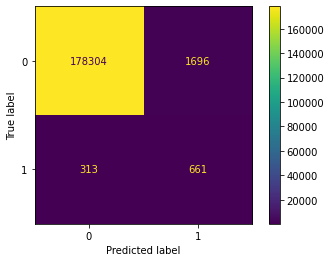

In [64]:
scores_and_plots(y_test, ypred_lgb_test, ypred_proba_lgb_test)

In [65]:
ypred_proba_xgb_test, ypred_xgb_test = reg_predict(xgb_models, X_test, y=y_test)

Model  0 accuracy score: 0.48524939529639816
Model  1 accuracy score: 0.46788602096438814
Model  2 accuracy score: 0.47692986629954676
Model  3 accuracy score: 0.48305098112015066
Model  4 accuracy score: 0.4795250358732251
Final test average precision score: 0.5035266471385574


In [85]:
ypred_proba_xgb_res_test, ypred_xgb_res_test = reg_predict(xgb_res_models, X_test, y=y_test)

Model  0 accuracy score: 0.48900452032245234
Model  1 accuracy score: 0.4880314181706584
Model  2 accuracy score: 0.48516634854386703
Model  3 accuracy score: 0.48549180900887867
Model  4 accuracy score: 0.4907201022868188
Final test average precision score: 0.5145318854855365


In [ ]:
threshold = 0.45
ypred_xgb_test = 1. * (ypred_proba_xgb_test > threshold)
ypred_xgb_res_test = 1. * (ypred_proba_xgb_res_test > threshold)

In [ ]:

scores_and_plots(y_test, ypred_xgb_test, ypred_proba_xgb_test)

In [ ]:
# The pure SMOTE model woeks better
scores_and_plots(y_test, ypred_xgb_res_test, ypred_proba_xgb_res_test)

In [92]:
ypred_xgb_2_test = 1. * ((0.5 * ypred_proba_xgb_test + 0.5 * ypred_proba_xgb_res_test) > 0.5)
ypred_proba_xgb_2_test = (0.5 * ypred_proba_xgb_test + 0.5 * ypred_proba_xgb_res_test)

Average Precision (AP): 0.51
Accuracy score: 0.99
Balanced accuracy score: 0.83
ROC: 0.8341545630846452


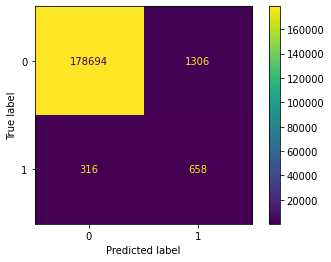

In [93]:
scores_and_plots(y_test, ypred_xgb_2_test, ypred_proba_xgb_2_test)

In [94]:
# Ensemble of LGB and XGBoost models
# less good model
ypred_test = 1. * ((0.5 * ypred_proba_lgb_test + 0.5 * ypred_proba_xgb_test) > 0.55)
ypred_proba_test = (0.5 * ypred_proba_lgb_test + 0.5 * ypred_proba_xgb_test)

Average Precision (AP): 0.48
Accuracy score: 0.99
Balanced accuracy score: 0.82
ROC: 0.8245593029888203


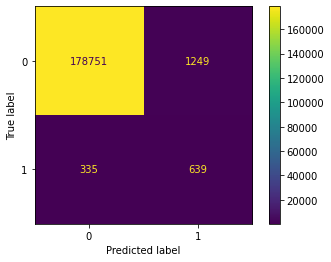

In [95]:
scores_and_plots(y_test, ypred_test, ypred_proba_test)

# Plotting the distribution of binding vs non-binding

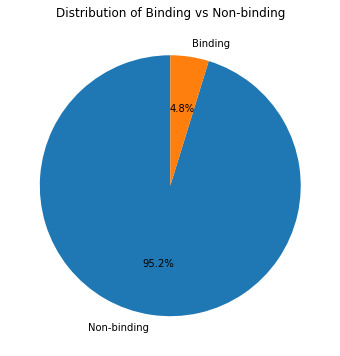

In [69]:

plt.figure(figsize=(8, 6))
plt.pie(df['binds'].value_counts(), labels=['Non-binding', 'Binding'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Binding vs Non-binding')
plt.show()